In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
import random
from itertools import chain
from collections import Counter
import numpy as np
import scipy

from ipynb.fs.full.GenerateData import generatedata
from ipynb.fs.full.Logistic_Functions import sigmoid, initialize_params_w_zeros, propagate, optimize, predict

In [2]:
data = generatedata()

In [3]:
# check how many released/remanded
data.release.value_counts()

1    6956
0    4786
Name: release, dtype: int64

<BarContainer object of 10 artists>

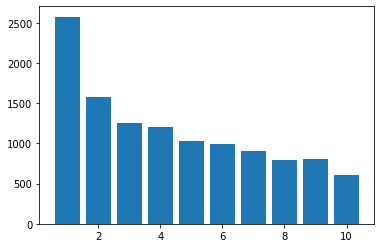

In [4]:
# plot the districution of decile scores

decile_count = Counter(data.decile_score)

dc_lists = sorted(decile_count.items()) # sorted by key, return a list of tuples

x, y = zip(*dc_lists) # unpack a list of pairs into two tuples

plt.bar(x, y)


In [5]:
# check how many released/remanded by decile_score
pd.crosstab(data.decile_score, data.release)

release,0,1
decile_score,,
1,1287,1290
2,155,1417
3,613,646
4,1082,117
5,99,935
6,96,897
7,456,444
8,382,414
9,79,723


In [6]:
# select out relevant data & generate the train and test data
# for now, we're only going off of the risk assessment score
data = data[['release','decile_score']]

# train / test
X = data.drop(['release'],axis=1)
y = data['release']
class_names = data.release.unique()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
# Start with a really basic baseline model
# Going to use dummy classifier - this will only predict the majority case (i.e. release)

classify = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)
y_pred = classify.predict(X_test)

#Distribution of y test
print('y actual : \n' +  str(y_test.value_counts()))
print()

#Distribution of y predicted
print('y predicted : \n' + str(pd.Series(y_pred).value_counts()))
print()

# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print()
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print()
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print()
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print()

#Dummy Classifier Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))
print()

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classify, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)


In [ ]:
# next, we'll do a really simple logistic regression where the IV is simply the compas decile_score

logit_classify = LogisticRegression().fit(X_train,y_train)
logit_y_pred = logit_classify.predict(X_test)

# Model Evaluation metrics 

print('Accuracy Score : ' + str(accuracy_score(y_test,logit_y_pred)))
print()
print('Precision Score : ' + str(precision_score(y_test,logit_y_pred)))
print()
print('Recall Score : ' + str(recall_score(y_test,logit_y_pred)))
print()
print('F1 Score : ' + str(f1_score(y_test,logit_y_pred)))
print()

#Logistic Regression Classifier Confusion matrix & plot
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,logit_y_pred)))

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    logit_disp = plot_confusion_matrix(logit_classify, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(logit_disp.confusion_matrix)

In [10]:
# build a logit from scratch so that we can customize its components
z = data['decile_score']
test = sigmoid(z)
test.head()

0    0.731059
1    0.993307
2    0.952574
3    0.982014
4    0.999665
Name: decile_score, dtype: float64

In [ ]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)